## Create Donut

In [82]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom
import numpy

def match_colorbar(ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-5 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = numpy.zeros(img.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    print('Fitted',a,b,c)
    #for k in range(n):
    #    new[y[k], x[k]] = img[ y[k], x[k]] - ( a*x[k] + b*y[k] + c )
    return new, a,b,c

def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def get_scan_step(oversampling,pixel_size,wavelength,distance):
    return wavelength*distance/(oversampling*pixel_size)

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def get_positions(scan_step,size_x,size_y):

    x_positions = np.arange(0,size_x,scan_step)
    y_positions = np.arange(0,size_y,scan_step)

    error = 0.05
    error2 = error
    
    x_pos = x_positions + np.random.normal(scale=error*scan_step,size=x_positions.shape)
    y_pos = y_positions + np.random.normal(scale=error*scan_step,size=y_positions.shape)

    x_pos_error = x_positions + np.random.normal(scale=error2*scan_step,size=x_positions.shape)
    y_pos_error = y_positions + np.random.normal(scale=error2*scan_step,size=y_positions.shape)

    return y_pos,x_pos, y_pos_error,x_pos_error

def set_object_size(x_pos,y_pos,obj_pxl_size,probe_size):
    gap = 10
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))//obj_pxl_size),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))//obj_pxl_size))


# Phantom Magnitude

In [139]:
N=250
magnitude = sscPhantom.mario.createMario(shape=N, noise=False, zoom=0.15)

mario: (250, 250, 250) 31.2MB


## Phantom Phase

In [135]:
params = { 'HowMany': 10,
           'radius': 0.07,
           'Rtorus': 0.5,
           'rtorus': 0.1}
nproc  = 16
energy = 7  #Kev
phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
phase = phantom1 + phantom2

--> ssc-phantom: particles generated / elapsed: 42.07054305076599
sscPhantom: creating 2 250x250x250 shared arrays (Phantom)
Done: 250 images within 3.464092969894409 sec
--> ssc-phantom: donuts created / elapsed: 3.4642436504364014


## Complex Phantom

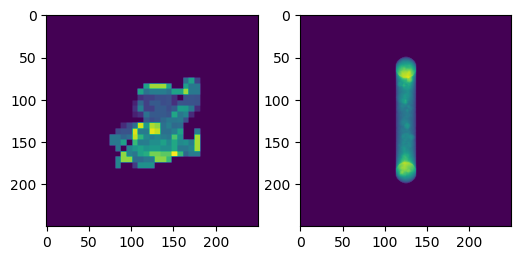

In [141]:
phantom = magnitude*np.exp(1j*phase)

figure, ax = plt.subplots(1,2,dpi=100)
ax[0].imshow(np.sum(magnitude,axis=2))
ax[1].imshow(np.sum(phase,axis=2))

## Rotate and get projections 

In [152]:
from scipy.ndimage import rotate

angles = np.linspace(0,180,2*N)
dtheta = angles[1]-angles[0]

if 0:
    sinogram = np.zeros((angles.shape[0],N,N),dtype=complex)

    for idx, angle in enumerate(angles):
        print(f'{idx}/{angles.shape[0]}')
        sinogram[idx,:,:] = np.sum(np.abs(rotate(magnitude,angle,reshape=False))*np.exp(1j*rotate(magnitude,angle,reshape=False)),axis=2)
else:
    np.save('complex_sinogram.npy',sinogram)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Probe and Object

In [122]:
size_y_pxl = 500
size_x_pxl = 400
obj = np.ones((size_y_pxl,size_x_pxl))

probe_pxl = 1.25156e-6
N = 8 # rescaling factor
probe_pxl = N*probe_pxl
probe = np.load('probe_at_focus_1.25156micros_pixel.npy')
print("Probe shape", probe.shape)
probe.resize((probe.shape[0]//N,probe.shape[1]//N)) 
print("Probe shape", probe.shape)

probe_size = (probe.shape[0]*probe_pxl,probe.shape[1]*probe_pxl)

energy = 1 #keV
c, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
wavelength = planck * c / energy # meters
distance = 1 #meter


obj_pxl = get_object_pixel(probe.shape[0],probe_pxl,wavelength, distance) # energy keV; distance meters

oversampling = 5
scan_step = get_scan_step(oversampling,probe_pxl,wavelength,distance)
size_y, size_x = obj_pxl*size_y_pxl, obj_pxl*size_x_pxl
print("Sample size [mm]:",size_y, size_x)

y_pos, x_pos, y_pos_error,x_pos_error = get_positions(scan_step,size_x,size_y)

obj_recon_size = set_object_size(x_pos,y_pos,obj_pxl,probe.shape)
obj = np.ones(obj_recon_size)
print(obj.shape)


border_gap = 10
x_pos_pxl = [np.int(x) for x in np.round((x_pos-np.min(x_pos))/obj_pxl)]
y_pos_pxl = [np.int(y) for y in np.round((y_pos-np.min(y_pos))/obj_pxl)]
print("Y positions [px]", y_pos_pxl)
print("X positions [px]", x_pos_pxl)

Ymesh, Xmesh = np.meshgrid(y_pos_pxl,x_pos_pxl)

probe = np.zeros_like(np.abs(probe))

DP_sinogram = np.zeros((Xmesh.flatten().shape[0],probe.shape[0],probe.shape[1]))
print(DP_sinogram.shape)
""" Loop through positions """ 
counter = 0
for y, x in zip(Ymesh.flatten(),Xmesh.flatten()):
    # print(y,y+probe.shape[0],x,x+probe.shape[1])
    wavefront_box = probe*obj[y:y+probe.shape[0],x:x+probe.shape[1]]
    
    """ Calculate Difpad """ 
    DP = np.abs(propagate_beam(wavefront_box, (obj_pxl,wavelength,distance)))**2
    
    """ Add errors to Difpad """ 
        # TODO
        
    """ Save Difpad to "Sinogram" """
    DP_sinogram[counter,:,:] = DP
    
    
    

Probe shape (800, 800)
Probe shape (100, 100)
Sample size [mm]: 0.0006191482898652948 0.0004953186318922358
(591, 490)
Y positions [px] [0, 21, 41, 60, 82, 98, 118, 138, 161, 180, 200, 219, 241, 259, 280, 300, 321, 339, 360, 379, 401, 422, 439, 460, 481]
X positions [px] [0, 19, 39, 61, 80, 100, 121, 139, 160, 180, 200, 221, 240, 259, 281, 300, 322, 340, 360, 380]
(500, 100, 100)


## Probe

In [ ]:

""" Unwrap """
# x = np.linspace(0,image0.shape[0]-1,image0.shape[0])
# X, Y = np.meshgrid(x,x)
# a=0.1
# b=0.2
# c=2
# plane = a*X+b*Y +c
# image = image0 + plane

# Get ptycho projection "box"

# Get difpad

# Store difpad

